In [1]:
import av
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import scipy
import face_alignment

In [2]:
container = av.open('../data/burpees_litup.mov')

In [3]:
for i, frame in enumerate(container.decode(video=0)):
    
    array = frame.to_ndarray(format='rgb24')
    break


In [4]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

In [5]:
landmarks = fa.get_landmarks(array)

In [6]:
type(landmarks[0])

numpy.ndarray

In [7]:
landmarks[0].shape

(68, 2)

In [8]:
landmarks[0][:];

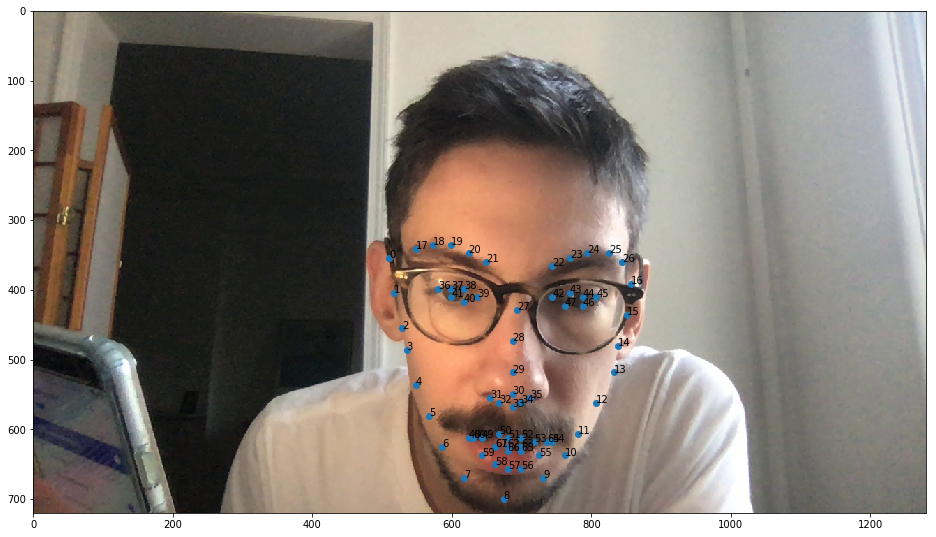

In [9]:
plt.figure(figsize=(16, 16))
plt.imshow(array)
plt.scatter(landmarks[0][:, 0], landmarks[0][:, 1])
for i, landmark in enumerate(landmarks[0][:]):
    plt.gca().annotate(str(i), (landmark[0], landmark[1]))

In [10]:
def positions_from_landmarks(landmarks):
    positions = []
    top_left_brow = landmarks[19]
    top_right_brow = landmarks[24]
    left_eye = landmarks[37]
    brow_eye_distance = np.linalg.norm(top_left_brow - left_eye)
    f_param = 4
    size = int(brow_eye_distance / f_param)
    positions.append((top_left_brow[0] , top_left_brow[1] - size*2))
    positions.append((top_right_brow[0] , top_right_brow[1] -size*2))
    positions.append((top_left_brow[0] , top_left_brow[1] - size*4))
    positions.append((top_right_brow[0] , top_right_brow[1] -size*4))
    positions.append(tuple(np.mean([positions[0], positions[1]], axis=0)))
    positions.append(tuple(np.mean([positions[2], positions[3]], axis=0)))
    
    
    
    return positions, int(size)

In [11]:
def convert_positions(positions):
    result = []
    for (x,y ) in positions:
        result.append((int(x), int(y)))
        
    return result

In [12]:
positions, size = positions_from_landmarks(landmarks[0])

In [13]:
positions

[(599.0, 305.0),
 (794.0, 317.0),
 (599.0, 275.0),
 (794.0, 287.0),
 (696.5, 311.0),
 (696.5, 281.0)]

In [14]:
positions = convert_positions(positions)

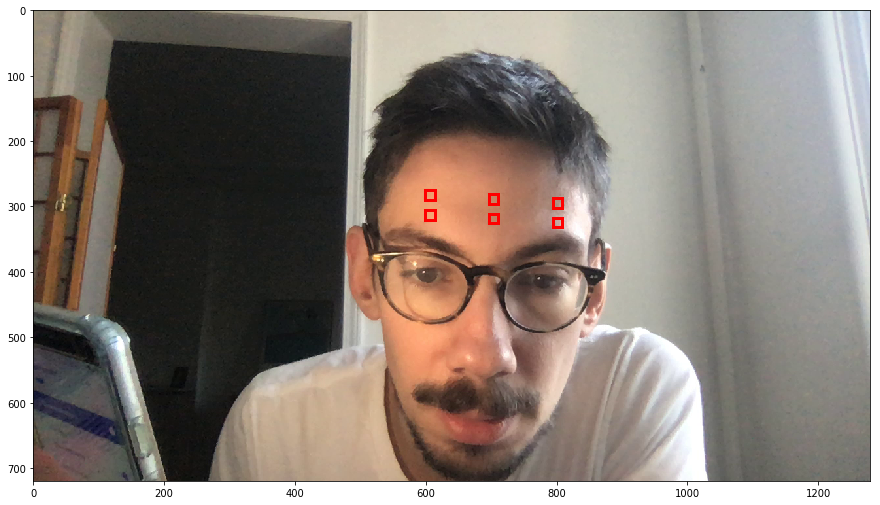

In [15]:
scale = 15
w, h = size, size
plt.figure(figsize=(scale, scale * 1280/720))
plt.imshow(array)
for xy in positions:
    plt.gca().add_patch(plt.Rectangle(xy, w, h, fill=False, edgecolor='r', linewidth=3))

In [16]:
result_dict = {}
for x, y in positions:
    result_dict[str((x))+ "," + str((y))] = []

In [17]:
for i, frame in enumerate(container.decode(video=0)):
    np_frame = frame.to_ndarray(format='rgb24')
    for x,y in positions:
        frame = np_frame[(y):((y)+w), (x):((x)+h), 1]
        result_dict[str(x)+","+str(y)].append(np.mean(frame))
        


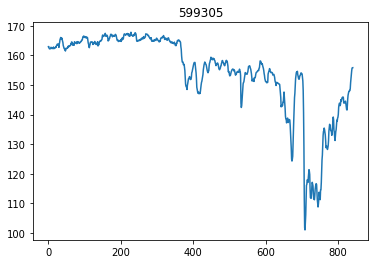

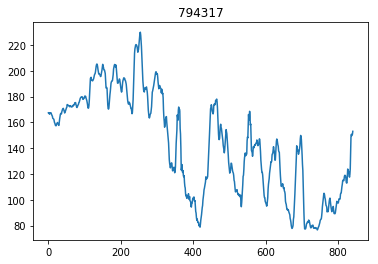

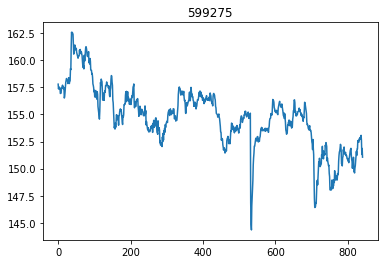

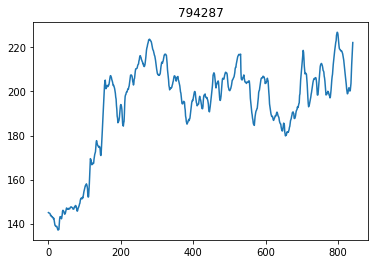

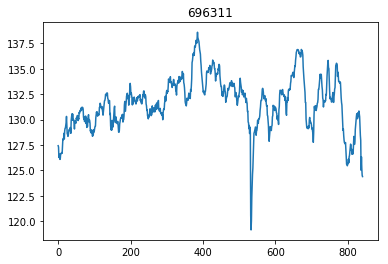

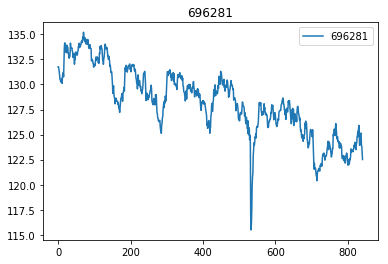

In [18]:
for x,y in positions:
    x = int(x)
    y = int(y)
    plt.figure()
    plt.title(str(x) + str(y))
    plt.plot(result_dict[str(x) + ',' + str(y)], label = str(x) + str(y))

plt.legend()

In [19]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [20]:
keys = [str(x) +',' + str(y) for (x,y) in positions ]

In [21]:
signals = [v for k,v in result_dict.items()]

In [22]:
signals = np.array(signals)

In [23]:
x = signals[0, :]
x = x - x[0]

In [24]:
ms = np.mean(signals, axis=0)

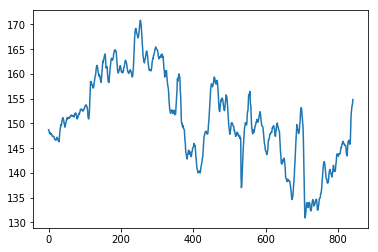

In [25]:
plt.plot(ms)

In [32]:
f, pxx = scipy.signal.welch(ms - ms[0], fs=30, nperseg=len(ms))

In [35]:
f[9], freq[9]

(0.32066508313539194, 1.0546875)

In [ ]:
plt.plot(f*60, pxx)
plt.xlim(0, 200)
plt.ylim(0, 8)

In [27]:
mask = ((f*60 > 50) &  (f*60 < 180))
pxx[~mask] = 0 
f[np.argmax(pxx)]*60

53.44418052256532

In [30]:
ms.shape

(842,)

In [31]:
freq, power = scipy.signal.welch(ms - ms[0], fs=30)

In [ ]:
# admissible heart rates: 30 - 220 bpm = .5 - 3.5 Hz 
# admissible BF: 10 - 60 bpm: .1 - 1 Hz

In [ ]:
def get_rates(signal, low_cutoff, hi_cutoff, sampling_f):
    signal = signal - signal[0]
    y = butter_bandpass_filter(signal, low_cutoff, hi_cutoff, sampling_f)
    f, Pxx_spec = scipy.signal.welch(y, sampling_f)
    rate = f[np.argmax(Pxx_spec)]
    return rate * 60

In [ ]:
for i, s in enumerate(signals):
    print("for signal " + str(i) + ":")
    ## HR
    hr = get_rates(s, .5, 3.5, 30)
    print("HR is :" + str(hr))
    br = get_rates(s, .2, 1, 30)
    print("Breathing Rate is :" + str(br))

In [ ]:
s = signals[5]
plt.plot(s)

In [ ]:
y = butter_bandpass_filter(s - s[0], .5, 2, 30)

In [ ]:
plt.plot(y)
plt.plot(s-s[5])

In [ ]:
f, Pxx_spec = scipy.signal.welch(s, 30, nperseg=1000, detrend='linear')

In [ ]:
breathing_freq = f[np.argmax(Pxx_spec)]
breathing_freq, breathing_freq * 60

In [ ]:
plt.plot(f, np.sqrt(Pxx_spec))
plt.xlim([0, 2])

In [ ]:
for i, s in enumerate(signals):
    f, Pxx_spec = scipy.signal.welch(s-s[0], 30, nperseg=1024)
    plt.plot(f, np.sqrt(Pxx_spec), label=str(i))
    plt.ylim([0, 7])
    plt.xlim([0.0, 1.5])
    plt.xlabel('frequency [Hz]')
    
plt.legend()

In [ ]:
breathing_freq = f[np.argmax(Pxx_spec)]
breathing_freq

In [ ]:
# breathing per minute
breathing_freq * 60

In [ ]:
## same exercise for bpm

In [ ]:
y = butter_bandpass_filter(x, .5, 3.5, 30)
plt.plot(y)

In [ ]:
f, Pxx_spec = scipy.signal.periodogram(y, 30, 'flattop', scaling='spectrum')

In [ ]:
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.ylim([1e-4, 1e1])
plt.xlabel('frequency [Hz]')

In [ ]:
hr = f[np.argmax(Pxx_spec)]

In [ ]:
# hr per minute
hr * 60

In [ ]:
## watch a little subvideo
container = av.open('test6.avi', mode='w')
stream = container.add_stream('mpeg4', rate=30)
stream.width = 1280
stream.height = 720
#stream.pix_fmt = 'yuv420p'

In [ ]:
source_container = av.open('../data/myface.mov')
source_images = []
for frame_i in source_container.decode(video=0):

    np_frame = frame_i.to_ndarray(format='rgb24')
    img = np.zeros((120, 120, 3))
    
    for x,y in positions:
        img[0:20, 0:20, :] = np_frame[y:(y+20), x:(x+20), 1].reshape(20, 20, 1)
        break
    source_images.append(img.astype(np.uint8))

In [ ]:
container = av.open('rea32.mp4', mode='w')
stream = container.add_stream('mpeg4', rate=30)
stream.width = 120
stream.height = 120
#stream.pix_fmt = 'yuv420p'

In [ ]:
len(source_images)

In [ ]:
for frame_i in range(len(source_images)):


    new_frame = av.VideoFrame.from_ndarray(source_images[frame_i])
    for packet in stream.encode(new_frame):
        container.mux(packet)

# Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()

In [ ]:
container.close()

In [ ]:
source_images[0]